In [2]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn3
import mca
import matplotlib.pyplot as plt


In [59]:
class Compare:
    """ 
    Compare -- plot collections for comparison purposes.
    
    Description:
        The purpose of this class is to take a series of collections and plot them so to show how they match.
        If the series is a dictionary, the keys will be used to create plot names.
        If the series contains two or three collections, then the plot will show venn diagrams and return a venn object
        that can be used for other purposes.
        If the series is greater than three, the plot will show the collections in a scatter plot based on correspondence
        scores.
    
    Parameters: 
        collections (required):  A list of lists or a dict() of size 2 or greater for comparison purposes. 
        names:  An optional list of names for the collections.  Must be equal in size to collections. If collections is 
            a dict, this parameter will be overwritten.
        index:  A list of index keys to create a sublist for the collections.
        var: An optional list for further categorization of the collection data (not fully implemented yet).
        REMOVE_SINGLES: (Default:True) For 4 collections or more, remove from the analysis any data points that are
            members of only one collection. This reduces the chance that a disproportionately large collection
            will be seen as an outlier merely because it is disproportionately large.
            
    """
    
    def __init__ (self, collections, names=[], index=[], var=[], REMOVE_SINGLES=True):
        self.collection_names = names
        self.index = index
        self.collections = collections
        self.REMOVE_SINGLES = REMOVE_SINGLES
        # if a dictionary is inputed, then get names from dictionary
        if isinstance(self.collections, dict):
            # print("dict passed")
            self.collection_names = [x for x in self.collections.keys()]
            self.collections = [x for x in self.collections.values()]
        if not self.collection_names:
            self.collection_names = range(1, len(collections)+1)
        # if index var is provided, use index to filter collection list
        if self.index:
            self.collections = self.sublist(self.collections, self.index)
            self.collection_names = self.sublist(self.collection_names, self.index)
        #two sample venn
        if len(self.collections) == 2:
            self.response = self.two_venn(self.collections)
        #three sample venn
        elif len(self.collections) == 3:
            self.response = self.three_venn(self.collections)
        #use mca for greater than three
        elif len(self.collections) >3:
            if var:
                self.var = var
            else: 
                self.var = []
            self.ca = self.ca(self.collections, self.collection_names)
        else:
            self.no_compare()
            
    def no_compare(self):
        return ("Need at least two collections to compare results.")
    #get a sublist from a list of indices
    def sublist (self, list1, list2):
        return([list1[x] for x in list2])        
    #get set of all items (unduplicated)
    def unionize (self, sets_list):
        return set().union(*sets_list)
    def two_venn (self, collections):
        return  (venn2([set(x) for x in collections], set_labels=self.collection_names))
    def three_venn (self, collections):
        return  (venn3([set(x) for x in collections], set_labels=self.collection_names))
    def ca(self, collections, names):
        # use dd to create a list of all websites in the collections
        print (names)
        dd = self.unionize(collections)
        d = [] #create
        e = []
        #labels
        fs, cos, cont = 'Factor Score','Squared cosines', 'Contributions x 1000'
        #populate table with matches for actors (weblists)
        for y in collections:
            d.append({x: x in y for x in dd})
        #if self.var:
        #    e = ({x.split(".")[0]: x.split(".")[1] for x in dd })
        df = pd.DataFrame(d, index=names)       
        if self.REMOVE_SINGLES:
            df = df.loc[:, df.sum(0) >1 ]
        #if self.var:
        #    df.loc[:,"SUFFIX"] = pd.Series(e, index=df.index)
        self.response = df.T
        counts = mca.mca(df)
        data = pd.DataFrame(columns=df.index, index=pd.MultiIndex
                      .from_product([[fs, cos, cont], range(1, 3)]))
        data.loc[fs,    :] = counts.fs_r(N=2).T
        points = data.loc[fs].values
        labels = data.columns.values
        plt.figure(figsize=(10,10))
        plt.margins(0.1)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.xlabel('Factor 1')
        plt.ylabel('Factor 2')
        plt.scatter(*points, s=120, marker='o', c='r', alpha=.5, linewidths=0)
        for label, x, y in zip(labels, *points):
            plt.annotate(label, xy=(x, y), xytext=(x + .03, y + .03))
        plt.show()
        return(data.T)
        

In [46]:
"""
Assuming a Warbase output like this:
 
 ['((201601,linkis.com),11102)\n', '((201601,m.youtube.com),8764)\n', '((201601,www.youtube.com),7481)\n']

in a series of files in a folder called 'assembled' you can generate a list of collections based on the websites
like this:
"""

#initialise vars:
collection = dict()
collection_2 = dict()
var = dict()

#establish the data folder
path = "assembled/"

#get the files
for filename in os.listdir(path):
    with open(path+filename, "r") as file:
        #split the data by comma and lose the closing url. Put it in a set to remove duplicates.
        collect = {line.translate(str.maketrans(')'," ")).split(",")[1] for line in file.readlines()}
        # result:  {'www.url1.suf', 'www.biglovely.url2.suf', 'education.url3.suf'}
        collect2 = [x.split(".")[-2]+"."+x.split(".")[-1] for x in collect]
        # result: ['url1.suf', 'url2.suf', 'url3.suf']  (this decreases scope of analysis - removes "education" 
        # in education.ab.ca), for example.
        collect4 = [x for x in collect]
        # result merely converts each set to a big list of urls. (Full scope of analysis)
        collection[filename[0:10]] = (collect2) #convert collect2 to a dict {truncatedFILENAME: [url1.suf, url2.suf, url3.suf]}
        collection_2[filename[0:10]] = (collect4) #convert collect4 to a dict.

#Just separate the names and values for now.
comparit = [x for x in collection_2.values()]
names = [x.upper() for x in collection_2.keys()]

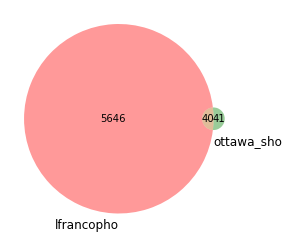

In [47]:
#Two collections
#Since collection is a dict() no need to include names.
compare1 = Compare(collection, index=[3,9])

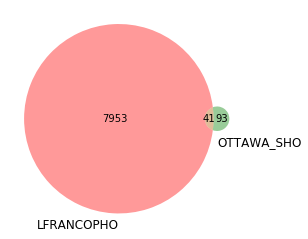

In [48]:
#Although you can add your own names if you want to ...  (recall "names" is x.upper()))

compare1 = Compare(comparit, names=names, index=[3,9] )

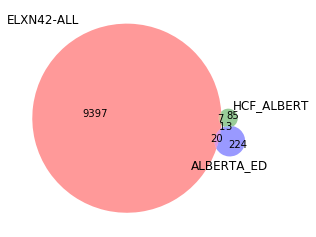

In [49]:
# What happens with three collections
compare2 = Compare(comparit, names, [0,5,14])

['ELXN42-ALL', 'ALBERTA_FL', 'HEALTH_SCI', 'ALBERTA_OI', 'OTTAWA_SHO', 'WEB_ARCHIV', 'HUMANITIES', 'CANADIAN_B', 'ALBERTA_ED']


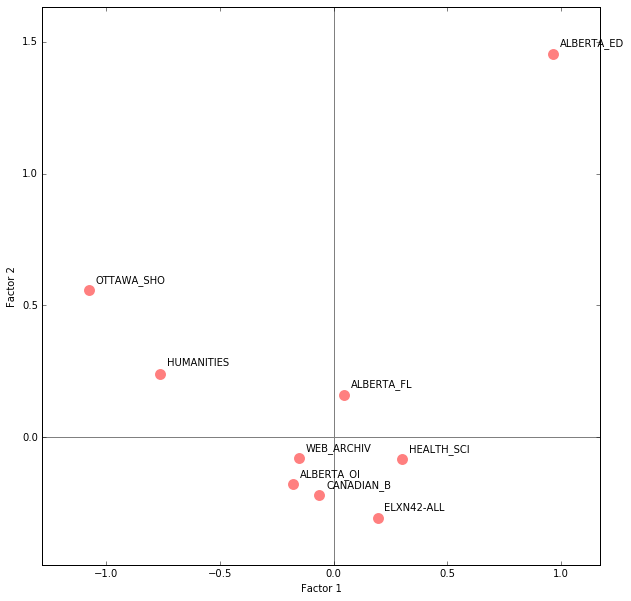

In [50]:
# With more than three collections, the output switches to correspondence analysis.
# Katherine Faust offers a great overview of the method here:
# www.socsci.uci.edu/~kfaust/faust/research/articles/articles.htm

# In this case, we've eliminated a few items from the analysis.

compare3 = Compare(comparit, names, [i for i, x in enumerate(comparit) if i not in [2,3,4,5,8,11]])

In [51]:
# Compare.ca stores the correspondence analysis (column) scores used for plotting.
print (compare3.ca)

           Factor Score            Squared cosines      Contributions x 1000  \
                      1          2               1    2                    1   
ELXN42-ALL      0.19353  -0.306999             NaN  NaN                  NaN   
ALBERTA_FL    0.0469354    0.16005             NaN  NaN                  NaN   
HEALTH_SCI     0.301339 -0.0839015             NaN  NaN                  NaN   
ALBERTA_OI     -0.17918  -0.179374             NaN  NaN                  NaN   
OTTAWA_SHO     -1.07616    0.55694             NaN  NaN                  NaN   
WEB_ARCHIV    -0.151306 -0.0805524             NaN  NaN                  NaN   
HUMANITIES    -0.764432   0.241071             NaN  NaN                  NaN   
CANADIAN_B   -0.0627609  -0.220619             NaN  NaN                  NaN   
ALBERTA_ED     0.967024    1.45503             NaN  NaN                  NaN   

                 
              2  
ELXN42-ALL  NaN  
ALBERTA_FL  NaN  
HEALTH_SCI  NaN  
ALBERTA_OI  NaN  
OTTAWA_SHO 

In [52]:
# Compare.response stores the table that these scores are based on (I've selected only 5 items for clarity)
#If REMOVE_SINGLES is not FALSE, then no row should contain fewer than two "TRUES".

print (compare3.response[10:15])

                      ELXN42-ALL ALBERTA_FL HEALTH_SCI ALBERTA_OI OTTAWA_SHO  \
ajax.googleapis.com        False      False       True      False      False   
aktrack.pubmatic.com       False      False      False      False       True   
alberta.ca                  True       True       True      False      False   
albertaventure.com          True      False      False       True      False   
allafrica.com               True      False      False      False      False   

                      WEB_ARCHIV HUMANITIES CANADIAN_B ALBERTA_ED  
ajax.googleapis.com         True      False      False      False  
aktrack.pubmatic.com        True       True      False      False  
alberta.ca                  True      False      False       True  
albertaventure.com         False      False       True      False  
allafrica.com               True      False      False      False  


test results for more than three
['ONE', 'TWO', 'THREE', 'FOUR', 'FIVE', 'SIX']


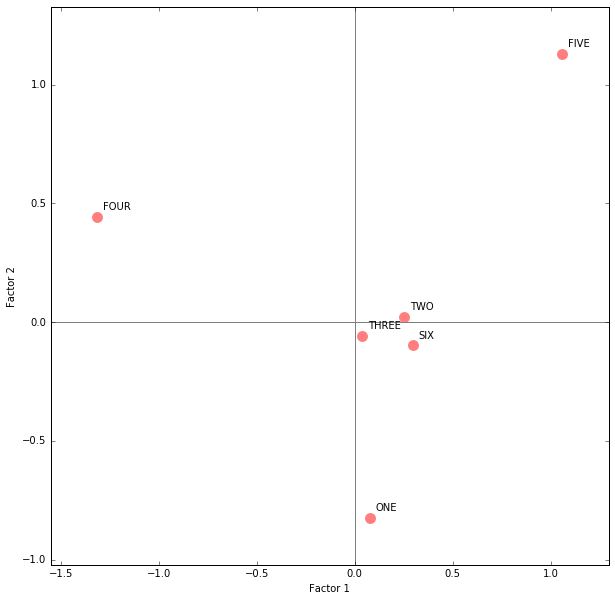

['ONE', 'TWO', 'THREE', 'FOUR', 'FIVE', 'SIX']


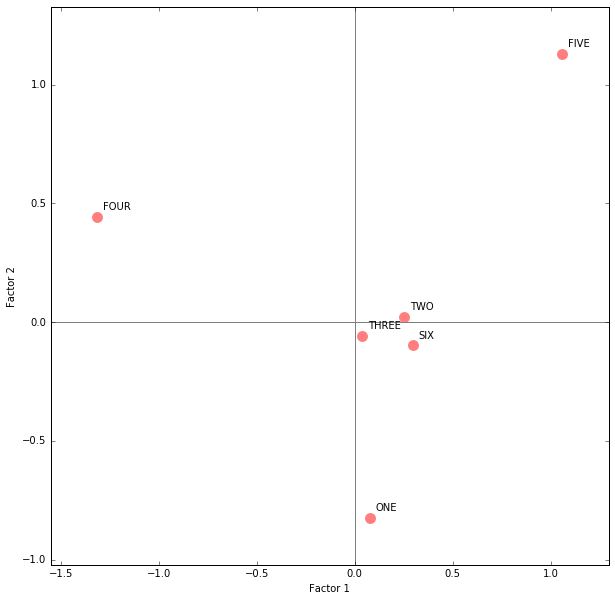

['ONE', 'TWO', 'THREE', 'FOUR', 'FIVE', 'SIX']


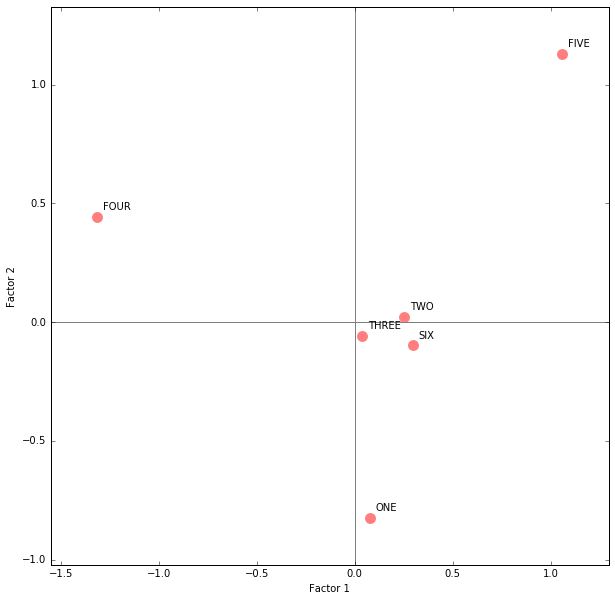

['ONE', 'TWO', 'THREE', 'FOUR', 'FIVE', 'SIX']


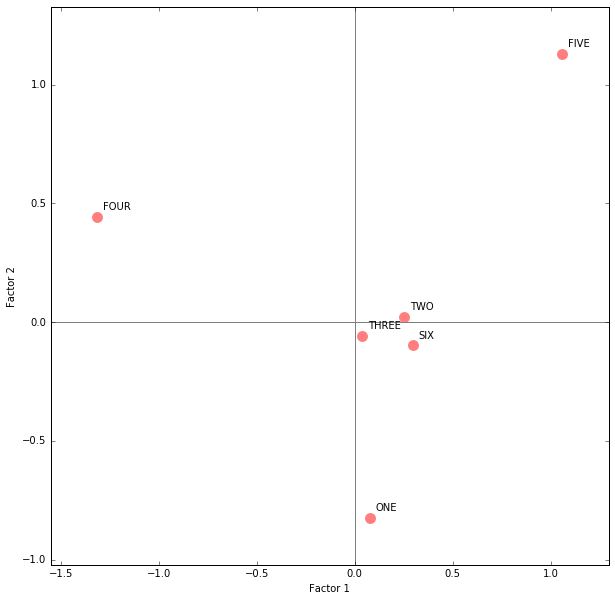

..

test error with one collection
test results for three


..

test results for two collections



----------------------------------------------------------------------
Ran 4 tests in 1.950s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

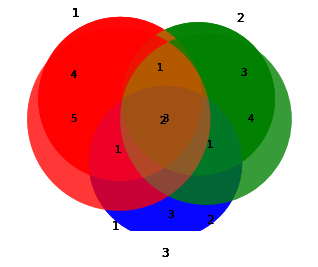

In [65]:
#Unit tests to be removed later.

import unittest

class CompareTests(unittest.TestCase):
    
    collection1 = ["google", "apple", "microsoft", "msn", "napster", "oracle", "amazon", "ibm"]
    collection2 = ["google", "pear", "thebeatles", "thepogues", "napster", "apple", "cow"]
    collection3 = ["google", "apple", "msn", "skunk", "beaver", "wolf", "cow"]
    collection4 = ["apple", "jump", "walk", "run", "saunter", "skunk", "napster"]
    collection5 = ["pear", "wolf", "jive", "tango"]
    collection6 = ["google", "apple", "msn", "thepogues", "napster", "wolf", "amazon", "tango"]
    one_collect = [collection1]
    two_collect = [collection1, collection2]
    three_collect = [collection1, collection2, collection3]
    all_collect = [collection1, collection2, collection3, collection4, collection5, collection6]
    
    def test_one (self):
        print("test error with one collection")
        self.assertTrue(Compare(one_collect), "Need at least two collections to compare results.")
        
    def test_two (self):
        print ("test results for two collections")
        self.assertTrue(Compare(two_collect).response.subset_labels[1].get_text(), 4)
        self.assertTrue(Compare(two_collect).response.subset_labels[0].get_text(), 5)
        self.assertTrue(Compare(two_collect).response.subset_labels[2].get_text(), 3)
    
    def test_three (self):
        print("test results for three")
        self.assertTrue(Compare(self.three_collect).response.subset_labels[0].get_text(), 4)
        self.assertTrue(Compare(self.three_collect).response.subset_labels[1].get_text(), 3)
        self.assertTrue(Compare(self.three_collect).response.subset_labels[0].get_text(), 1)
        self.assertTrue(Compare(self.three_collect).response.subset_labels[0].get_text(), 3)
        self.assertTrue(Compare(self.three_collect).response.subset_labels[0].get_text(), 1)
        self.assertTrue(Compare(self.three_collect).response.subset_labels[0].get_text(), 1)
        self.assertTrue(Compare(self.three_collect).response.subset_labels[0].get_text(), 2)
    
    def test_all (self):
        print("test results for more than three")
        test=Compare(all_collect, names=["ONE", "TWO", "THREE", "FOUR", "FIVE", "SIX"], REMOVE_SINGLES=False)
        self.assertTrue(list(Compare(all_collect, names=["ONE", "TWO", "THREE", "FOUR", "FIVE", "SIX"], REMOVE_SINGLES=False).response.iloc[1].values), 
                        [True, True, True, True, False, True])
        self.assertTrue(list(Compare(all_collect, names=["ONE", "TWO", "THREE", "FOUR", "FIVE", "SIX"], REMOVE_SINGLES=False).response.ix['amazon'].values),
                        [True, False, False, False, False, True])
        self.assertTrue(list(Compare(all_collect, names=["ONE", "TWO", "THREE", "FOUR", "FIVE", "SIX"], REMOVE_SINGLES=False).response.iloc[5].values),
                        [True, False, False, False, False, False])
        
        
        

suite = unittest.TestLoader().loadTestsFromTestCase(CompareTests)
unittest.TextTestRunner().run(suite)
        

In [31]:
    
compare3.ca.loc[:,'SUFFIX'] = pd.Series(var, index=compare3.ca.index)
print (compare3.ca)
compare3.ca.to_csv("output.csv",  encoding='utf-8')


           Factor Score            Squared cosines      Contributions x 1000  \
                      1          2               1    2                    1   
ELXN42-ALL      0.19353  -0.306999             NaN  NaN                  NaN   
ALBERTA_FL    0.0469354    0.16005             NaN  NaN                  NaN   
HEALTH_SCI     0.301339 -0.0839015             NaN  NaN                  NaN   
ALBERTA_OI     -0.17918  -0.179374             NaN  NaN                  NaN   
OTTAWA_SHO     -1.07616    0.55694             NaN  NaN                  NaN   
WEB_ARCHIV    -0.151306 -0.0805524             NaN  NaN                  NaN   
HUMANITIES    -0.764432   0.241071             NaN  NaN                  NaN   
CANADIAN_B   -0.0627609  -0.220619             NaN  NaN                  NaN   
ALBERTA_ED     0.967024    1.45503             NaN  NaN                  NaN   

                SUFFIX  
              2         
ELXN42-ALL  NaN    NaN  
ALBERTA_FL  NaN    NaN  
HEALTH_SCI  NaN    